# Predicting Adult Height

Predicting adult height with a simple linear model. Also playing with a bayesian linear model just so I can better see the uncertainity. (Yes all heights are in inches)

In [1]:
import numpy as np
import pymc3 as pm
import pandas as pd
import statsmodels.formula.api as smf
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as graph
from IPython.display import display, Markdown

graph.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv(
    'https://raw.githubusercontent.com/SKKSaikia/MicrosoftLearning-Data.Science.Essentials/master/Mod3/GaltonFamilies.csv',
    index_col=0
)
df['isMale'] = (df['gender'] == 'male').astype(int)

print(df.shape)
display(df.head())

(934, 9)


,family,father,mother,midparentHeight,children,childNum,gender,childHeight,isMale
Case,,,,,,,,,
1,1,78.5,67.0,75.43,4,1,male,73.2,1
2,1,78.5,67.0,75.43,4,2,female,69.2,0
3,1,78.5,67.0,75.43,4,3,female,69.0,0
4,1,78.5,67.0,75.43,4,4,female,69.0,0
5,2,75.5,66.5,73.66,4,1,male,73.5,1


In [3]:
print(f'Number of families = {len(df.family.unique())}')

Number of families = 205


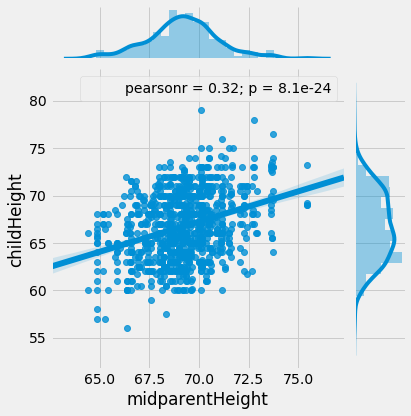

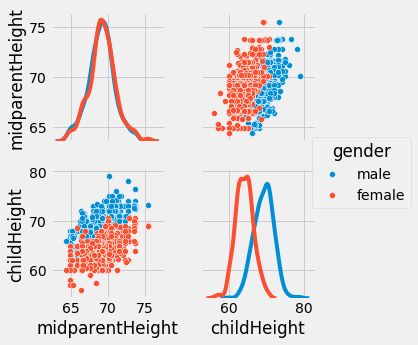

In [4]:
sns.jointplot(df['midparentHeight'], df['childHeight'], kind='reg')
graph.show()

sns.pairplot(data=df[['midparentHeight', 'childHeight', 'gender']], hue='gender', diag_kind='kde')
graph.show()

# Model the problem

In [5]:
df.columns

Index(['family', 'father', 'mother', 'midparentHeight', 'children', 'childNum',
       'gender', 'childHeight', 'isMale'],
      dtype='object')

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            childHeight   No. Observations:                  934
Model:                            GLM   Df Residuals:                      930
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                   4.68588696215
Method:                          IRLS   Log-Likelihood:                -2044.6
Date:                Sat, 30 Dec 2017   Deviance:                       4357.9
Time:                        11:40:41   Pearson chi2:                 4.36e+03
No. Iterations:                     2                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            16.5212      2.727      6.058      0.000      11.176      21.866
C(gender)[T.male]     5.2150      0.142     36.775      0.000       4.937       5.493
father                0.3928      0.029     13.699      0.000       0.337       0.449
mother                0.3176      0.031     10.245      0.000       0.257       0.378
=====================================================================================
"""

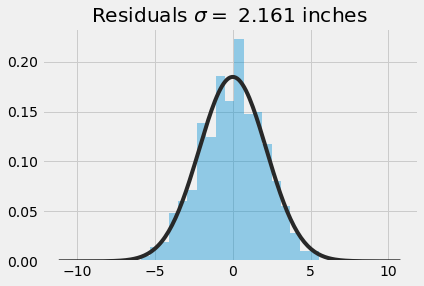

Wall time: 1.06 s


In [6]:
%%time
# Frequentist GLM
fglm = smf.glm('childHeight ~ father + mother + C(gender)', data=df).fit()

display(fglm.summary())

graph.title(f'Residuals $\sigma =$ {fglm.resid_pearson.std():0.3f} inches')
sns.distplot(fglm.resid_pearson, fit=stats.norm, kde=False)
graph.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10500/10500 [09:13<00:00, 16.67it/s]C:\Users\antho\Miniconda3\lib\site-packages\pymc3\step_methods\hmc\nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.886690013824, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



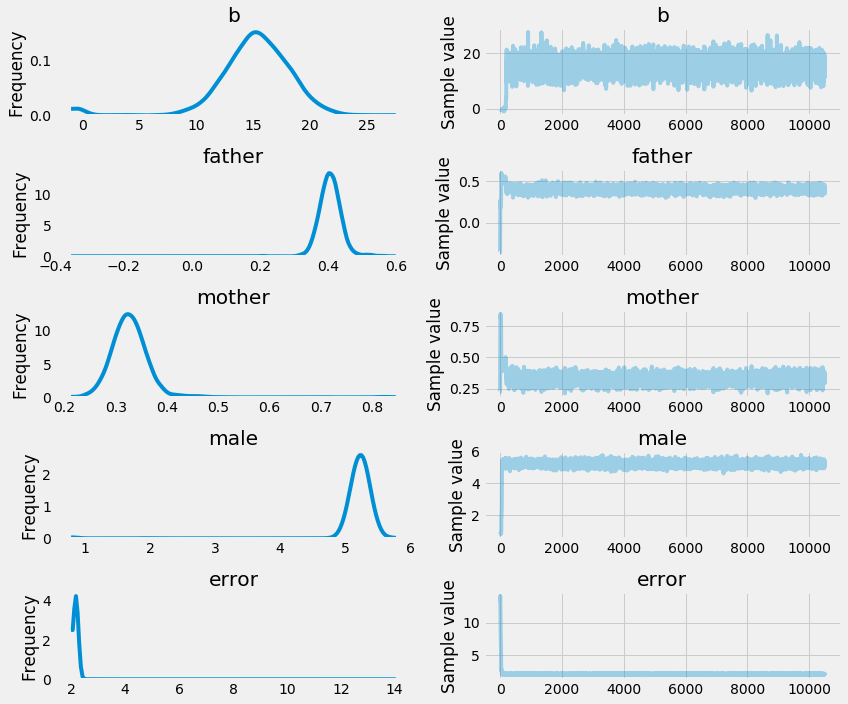

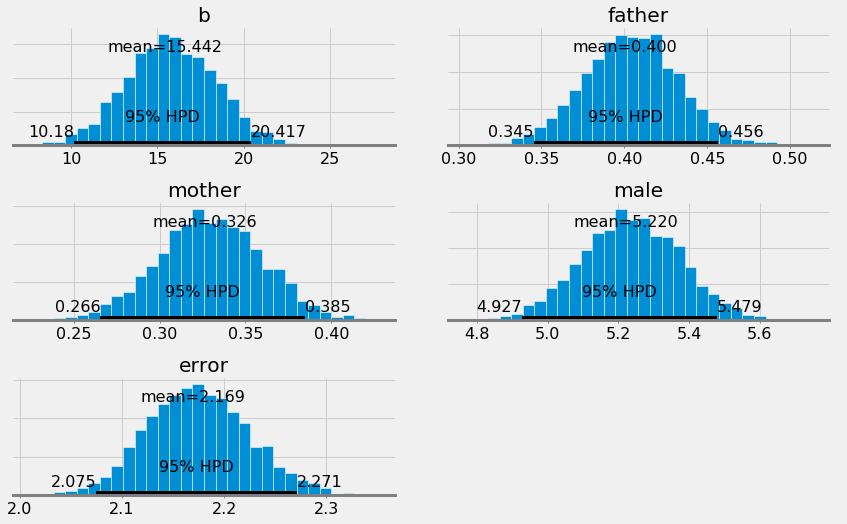

Wall time: 9min 34s


In [7]:
%%time
with pm.Model() as bayes_regression:
    # Priors Bayesian GLM
    # childHeight ~ father + mother + C(gender)
    error = pm.Uniform('error', lower=0, upper=25)
    b = pm.Normal('b', mu=0, sd=10)
    father = pm.Normal('father', mu=0, sd=1)
    mother = pm.Normal('mother', mu=0, sd=1)
    male = pm.Normal('male', mu=0, sd=10)
    
    # Model
    obs = pm.Normal(
        'y', 
        mu=(father * df['father']) + (mother * df['mother']) + (male * df['isMale']) + b, sd=error,
        observed=df['childHeight']
    )
    
    # Sample
    trace = pm.sample(int(10e3), init='jitter+adapt_diag', n_init=1000, discard_tuned_samples=False)
    
    # Posterior
    pm.traceplot(trace)
    graph.show()
    
    trace = trace[1000::3]  # Verified with autocorrelation plots
    
    pm.plot_posterior(trace)
    graph.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 317.28it/s]


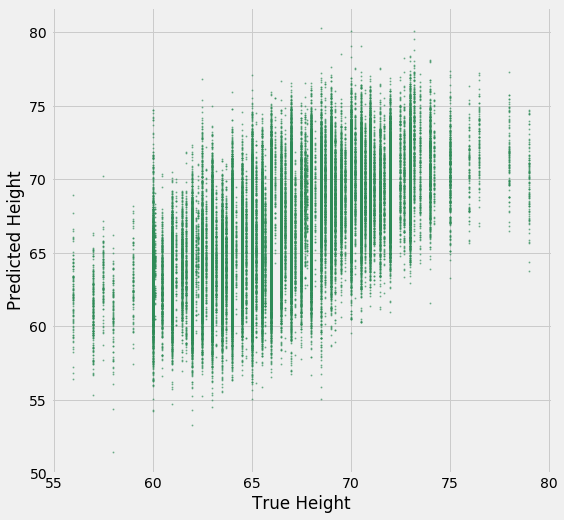

In [8]:
# Predictive Posterior Checks
graph.figure(figsize=(8, 8))
for row in zip(df['childHeight'], pm.sample_ppc(trace, samples=100, model=bayes_regression)['y'].T):
    graph.plot(row[0] * np.ones(row[1].shape), row[1], 'o', markersize=1, color='seagreen', alpha=0.5)
graph.xlabel('True Height')
graph.ylabel('Predicted Height')
graph.show()

# Getting Predictions From Models

In [9]:
def create_point(mom, dad, gender):
    p = pd.DataFrame(
        {'mother': mom, 'father': dad, 'gender': 'female' if 'f' in gender else 'male'},
        index=[0]
    )
    p['isMale'] = (p['gender'] == 'male').astype(int)
    return p

In [10]:
def point_estimate(mom, dad, gender):
    """Frequentist single point estimate"""
    point = create_point(mom, dad, gender)
    return fglm.predict(point)[0]

display(Markdown(f'Annie estimated at {point_estimate(71, 67, "f"):0.2f} inches'))
display(Markdown(f'Anthony estimated at {point_estimate(62, 67, "m"):0.2f} inches'))

Annie estimated at 65.39 inches

Anthony estimated at 67.75 inches

In [11]:
# Posterior parameters
trace_df = pm.trace_to_dataframe(trace)
display(trace_df.head(3))

,b,father,mother,male,error
0,18.170977,0.338574,0.350444,5.455902,2.112184
1,16.243986,0.377004,0.340961,5.028617,2.154605
2,13.991973,0.422795,0.327075,5.150672,2.095665


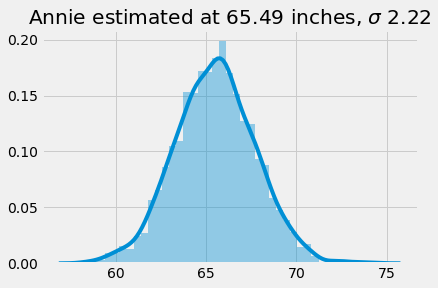

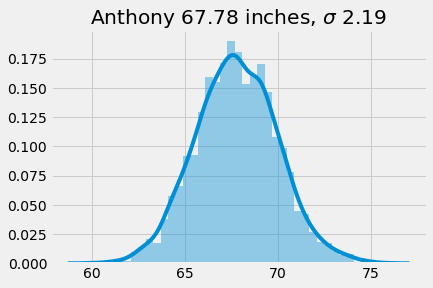

In [12]:
def bayes_estimate(mom, dad, gender):
    point = create_point(mom, dad, gender)
    est = []
    for _, row in trace_df.iterrows():
        p = ((row['father'] * point['father']) + (row['mother'] * point['mother']) + (row['male'] * point['isMale']) + row['b'])
        p += stats.norm.rvs(loc=0, scale=row['error'], size=1)
        est.append(p)
    return np.array(est).flatten()

# Test Values
annie = bayes_estimate(71, 67, 'f')
graph.title(f'Annie estimated at {annie.mean():0.2f} inches, $\sigma$ {annie.std():0.2f}')
sns.distplot(annie)
graph.show()

anthony = bayes_estimate(62, 67, 'm')
graph.title(f'Anthony {anthony.mean():0.2f} inches, $\sigma$ {anthony.std():0.2f}')
sns.distplot(anthony)
graph.show()

# Great!

type in heights and gender below to play with predictions

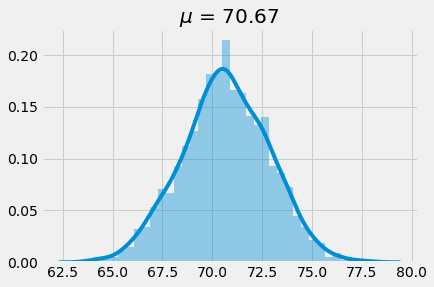

In [13]:
test_point = bayes_estimate(71, 67, 'm')
graph.title(f'$\mu$ = {test_point.mean():0.2f}')
sns.distplot(test_point)
graph.show()